# Отток клиентов банка.

На основе исторических данных о поведении клиентов банка необходимо спрогнозировать значение целевого признака - уйдёт клиент из банка в ближайшее время или нет.

Основная задача - найти и построить модель с предельно большим значением *F1*-меры. Выбранную нужно довести метрику до 0.59.

Дополнительно измерим *AUC-ROC*, сравнивним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## План действий:

### [1. Изучение общей информации о данных](#intro)
 - [Первичный просмотр данных](#start)
 - [Предобработка данных](#prepare)

### [2. Исследование задачи](#task)
 - [Модель логистической регрессии.](#LogisticRegression)
 - [Модель случайного леса.](#RandomForestClassifier)
 - [Catboost classifier.](#Catboost)

### [3. Борьба с дисбалансом](#balance)
 - [Изменение параметра weight](#weight)
 - [Увеличение выборки](#upsample)
 - [Уменьшение выборки](#downsample)

### [4. Тестирование модели](#test)
 - [ROC-curve (и метрика AUC-ROC)](#auc-roc)

### [Общий вывод](#summary)

# 1. Изучение общей информации о данных <a id="intro"></a>
Осуществляем загрузку и подготовку данных.

## Первичный просмотр данных <a id="start"></a>
Проверим какие форматы используются в данных, а также проверим их на наличие пропущенных значений. В столбце CustomerId должны быть уникальные значения исходя из описания данных.

In [1]:
# Импортируем...

# ...основные библиотеки,
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... методы обрбаотки, подготовки и вывода данных,
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from catboost.utils import get_roc_curve

# ...модели и их метрики.
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV


# В процессе  могу появиться некритичные ошибки. Скроем их.
import warnings
warnings.filterwarnings("ignore")

# Открываем файл, выводим основную информацию по нему
data = pd.read_csv('/datasets/Churn.csv')
display(data.info())
print('Количество дублей:', data.duplicated().sum())
print('Количество дублей в столбце CustomerId:', data.duplicated(subset = ['CustomerId']).sum())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

Количество дублей: 0
Количество дублей в столбце CustomerId: 0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Есть пропущенные значения в столбце Tenure — не во всех случаях известно количество недвижимости у клиента. Этот же столбец по смыслу указанных в нём данных должен иметь целочисленный формат. В остальном данные отражены корректно и в полном объёме. 
Правда если смотреть с точки зрения готовности данных для обучения моделей - то в данном случае есть необходимость в дополнительной предобработке, которую мы и осуществим.

## Предобработка данных <a id="prepare"></a>

Из таблицы мы уберём колонки, которые не влияют на целевые признаки, и будут лишь добавлять шум в обучение моделей. Такие признаки как: номер столбца, ID пользователя и его имя, едва ли влияют на решение об отказе от использования продуктов - при их обработке модель будет учиться искать взаимосвязи там, где их нет.

In [2]:
# Уберём ненужные колонки
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1)

Ко всему датафрейму применим технику One-Hot Encoding для преобразования категориальных переменных в численные (их всего две). Передадим аргумент drop_first=True, чтобы не попасть в дамми-ловушку. А столбец с данными о количестве недвижимости у клиента  заполним их медианной, чтобы избавить его от пропущенных значений.

In [3]:
# Применим технику One-Hot Encoding
data = pd.get_dummies(data, drop_first=True)

# Заполним пропущенные значения в столбце 'Tenure'
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

# Проверим заполнение пропусков
print('Количество пропущенных значений в столбце Tenure:', data['Tenure'].isna().sum())

Количество пропущенных значений в столбце Tenure: 0


В данных присутствуют количественные признаки с разным разбросом значений. Вполне возможно, что для более качественного применения машинного обучения потребуется дополнительная предобработка путём стандартизации данных. Создадим дополнительный DataFrame на этот случай, но только после того как "отрежем" часть данных для тестовой выборки.

In [4]:
# Разделение выборок с применением стратификации (на тестовую и обучающую)
data, data_test = train_test_split(data, test_size=0.1, random_state=12345, stratify=data['Exited'])

# Стандартизируем данные 
features_values = data.drop(['Exited'], axis=1)
scaled_values = StandardScaler().fit_transform(features_values.values)
scaled_data = pd.DataFrame(scaled_values, index=features_values.index, columns=features_values.columns)
scaled_data['Exited'] = data['Exited']

Посмотрим, что в итоге получилось после предобработки данных.

In [5]:
# Выведем предобработанные данные
print('Стандартизированный DataFrame:')
display(scaled_data.head())
print('')
print('Предобработанный DataFrame без стандартизации:')
display(data.head())
print('')

# Выводем информацию о полученных выборках
print('Размеры выборок:')
print('Обучающая + Валидационная (ДатаФрейм data):', data.shape[0])
print('Тестовая:', data_test.shape[0])
print('')
print('Процент ушедших клиентов в выборках')
print('В обучающей и валидационной: {:.2%}' .format(data.query('Exited == 1').shape[0] / data.shape[0]))
print('В тестовой выборке: {:.2%}'.format(data_test.query('Exited == 1').shape[0] / data_test.shape[0]))

Стандартизированный DataFrame:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Exited
8834,0.073807,-0.469049,-0.727682,0.490126,-0.911343,0.647388,-1.030693,0.931003,-0.579061,-0.574442,0.912685,0
9524,2.071453,-0.087657,-0.002257,1.125440,-0.911343,0.647388,-1.030693,-0.382992,1.726934,-0.574442,0.912685,0
7723,0.425724,-0.373701,0.360456,-1.227826,0.808172,-1.544670,0.970221,1.350476,-0.579061,1.740819,0.912685,0
2553,0.798342,3.058828,1.085881,-1.227826,-0.911343,0.647388,0.970221,1.705072,-0.579061,1.740819,0.912685,1
1687,2.071453,-0.183005,-0.364969,0.972274,-0.911343,0.647388,0.970221,-1.241355,-0.579061,1.740819,0.912685,0



Предобработанный DataFrame без стандартизации:


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
8834,657,34,3.0,107136.60,1,1,0,153895.46,0,0,0,1
9524,850,38,5.0,146756.68,1,1,0,78268.61,0,1,0,1
7723,691,35,6.0,0.00,2,0,1,178038.17,0,0,1,1
2553,727,71,8.0,0.00,1,1,1,198446.91,1,0,1,1
1687,850,37,4.0,137204.77,1,1,1,28865.59,0,0,1,1



Размеры выборок:
Обучающая + Валидационная (ДатаФрейм data): 9000
Тестовая: 1000

Процент ушедших клиентов в выборках
В обучающей и валидационной: 20.37%
В тестовой выборке: 20.40%


**Итоги по первому пункту:**
Данные предобработаны. На всякий случай оставили два датафрейма - в одном из них данные были стандартизированы. Проверим насколько наши модели нуждаются в подобном шаге (во многих моделях этот процесс должен быть предусмотрен по умолчанию). 

Уже на этапе изучениия данных можно сделать вывод насколько классы не сбалансированы - в целевом признаке примерно в 20 % случаев встречается класс "1" (клиент ушёл из банка), и почти в 80 % класс "0" (клиент не ушёл из банка). 

# 2. Исследование задачи <a id="task"></a>
Пока что не будем принимать во внимание факт различия объемов классов почти в 4 раза, и проведём исследование задачи и обучение модели без учёта дисбаланса. 

Рассматривать будем три основных модели:
 1. [Модель логистической регрессии.](#LogisticRegression)
 2. [Модель случайного леса.](#RandomForestClassifier)
 3. [Catboost classifier.](#Catboost)
 
Для каждой модели посчитаем качество модели (ориентироваться будем на F1-меру). Данные выведем по обучающей и валидационной выборке, чтобы оценить переобучаемость моделей. Дополнительно оценим общее время работы функций обучения моделей, и вывода метрики по ним.
 
Так как по ходу проекта нам понадобится менять данные перед обучением моделей (при балансировке), обучение и вывод метрик будем проводить внутри функций. Дополнительно напишем функцию для выделения в выборках столбцов с целевыми и нецелевыми признаками). Сами выборки (обучающую и валидационную) определим сразу, и будем передавать их в функции.

В конце попробуем [обучить наши модели на стандартизированных данных](#Scaled_fit), проверим насколько этот процесс будет полезен для улучшения качества. 

In [6]:
# Напишем функцию выделения в выборках столбцов с целевыми и нецелевыми признаками.
def split_data(data_train, data_valid, target):

    features_train = data_train.drop([target], axis=1)
    target_train = data_train[target]
    
    features_valid = data_valid.drop([target], axis=1)
    target_valid = data_valid[target]
    

    return target_train, features_train, target_valid, features_valid

# Определим обучающую и валидационную выборки и выведем их размеры
data_train, data_valid = train_test_split(data, test_size=0.1, random_state=12345, stratify=data['Exited'])
print('Размеры выборок:')
print('Обучающая:', data_train.shape[0])
print('Валидационная:', data_valid.shape[0])
print('')
print('Процент ушедших клиентов в выборках')
print('В обучающей выборки: {:.2%}' .format(data_train.query('Exited == 1').shape[0] / data_train.shape[0]))
print('В валидационной выборке: {:.2%}'.format(data_valid.query('Exited == 1').shape[0] / data_valid.shape[0]))

Размеры выборок:
Обучающая: 8100
Валидационная: 900

Процент ушедших клиентов в выборках
В обучающей выборки: 20.37%
В валидационной выборке: 20.33%


## 2.1 Модель логистической регрессии <a id="LogisticRegression"></a>

В логистической регрессии поменяем только гиперпараметр solver - в прошлом проекте значение 'newton-cg' в нём позволило поднять точность модели. При необходимости в функцию можно будет передать модель с другими гиперпараметрами.

In [7]:
%%time

# Напишем функцию обучения и тестирования модели.
def model1_def (data_train, data_valid, target, model):
    target_train, features_train, target_valid, features_valid = split_data(data_train, data_valid, target)
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    train_predictions = model.predict(features_train)
    print('F1-мера модели на валидационной выборке: {:.3f}' .format(f1_score(target_valid, valid_predictions)))
    print('F1-мера модели на тренировочной выборке: {:.3f}' .format(f1_score(target_train, train_predictions)))
    print('ROC-AUC, полученный на валидационной выборке: {:.3f}' .format(roc_auc_score(target_valid, valid_predictions)))
    print('')


# Зададим параметры модели, и применим функцию
model1 = LogisticRegression(random_state=12345, solver='newton-cg')
model1_def (data_train, data_valid, 'Exited', model1)
print('Время выполнения кода:')

F1-мера модели на валидационной выборке: 0.308
F1-мера модели на тренировочной выборке: 0.321
ROC-AUC, полученный на валидационной выборке: 0.585

Время выполнения кода:
CPU times: user 4.31 s, sys: 5.15 s, total: 9.46 s
Wall time: 9.41 s


Качество получилось совсем низким, и вряд ли его получится существенно поднять только изменением гиперпараметров - здесь нужны более радикальные меры. Пока отложим логистическую регрессию и посмотрим на другие модели.

## 2.2 Модель случайного леса <a id="RandomForestClassifier"></a>

У модели случайного леса сделаем перебор гиперпараметров n_estimators и max_depth в цикле, чтобы найти наиболее качественную модель. В зависимости от аргумента "result" функция будет либо просто выводить параметры и значение F1-меры наилучшей модели, либо саму модель (для дальнейшего использования).

In [8]:
%%time

# Напишем функцию обучения и тестирования модели.
def model2_def (data_train, data_valid, target, result):
    
    # Определение переменных и выборок
    target_train, features_train, target_valid, features_valid = split_data(data_train, data_valid, target)
    best_est = 0
    best_depth = 0
    best_f1_score = 0
    best_model = None
    
    # Поиск лучшей модели
    for est in range(10, 151, 10):
        for depth in range (1, 10):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
            model.fit(features_train, target_train) 
            valid_predictions = model.predict(features_valid)
            f1_score_result = f1_score(target_valid, valid_predictions)
            if f1_score_result > best_f1_score:
                best_est = est
                best_depth = depth
                best_f1_score = f1_score_result
                best_model = model
    
    # Вывод полученных результатов или модели, в зависимости от параметра result
    if result == 'metrics':
        valid_predictions = best_model.predict(features_valid)
        train_predictions = best_model.predict(features_train)
        print('Оптимальные параметры:')
        print('Оптимальное количество деревьев:', best_est)
        print('Лучшая глубина дерева:', best_depth)
        print('')
        print('F1-мера модели на валидационной выборке: {:.3f}' .format(f1_score(target_valid, valid_predictions)))
        print('F1-мера модели на тренировочной выборке: {:.3f}' .format(f1_score(target_train, train_predictions)))
        print('ROC-AUC, полученный на валидационной выборке: {:.3f}' .format(roc_auc_score(target_valid, valid_predictions)))
        print('')
    if result == 'model':
        return best_model

# Применим функцию
model2_def (data_train, data_valid, 'Exited', 'metrics')
print('Время выполнения кода:')

Оптимальные параметры:
Оптимальное количество деревьев: 40
Лучшая глубина дерева: 9

F1-мера модели на валидационной выборке: 0.566
F1-мера модели на тренировочной выборке: 0.652
ROC-AUC, полученный на валидационной выборке: 0.706

Время выполнения кода:
CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 1min 7s


Качество заметно выше, чем у логистической регрессии, и почти достигло необходимой величины F-меры (0.59), но быстродействие обучения и валидации модели наоборот заметно хуже. 

Недостаток перебора в цикле - нет возможности передать функции модель с заранее заданными гиперпараметрами - их поиск осуществляется уже в процессе выполнения функции. Проверим альтернативный метод поиска лучшей модели, который лишён этого изъяна.

### Grid search или поиск по сетке
Попробуем сделать код компактнее, а функцию более гибкой, при помощи метода поиска по сетке. Зададим те же параметры, сравним скорость работы. Посмотрим какие гиперпараметры по мнению Grid search являются наилучшими.

In [9]:
%%time

# Напишем функцию для поиска по сетке.
def model2_grid_search (data_train, data_valid, target, model, result):
 
    # Зададим параметры для поиска по сетке, определим выборки.
    target_train, features_train, target_valid, features_valid = split_data(data_train, data_valid, target)
    param_grid2 = {'n_estimators': [int (x) for x in np.arange(start = 10, stop = 151, step = 10)],
              'max_depth': [int (x) for x in np.arange(start = 1, stop = 11, step = 1)]}
    
    # Найдём наилучшие параметры, и обучим по ним модель.
    model2_Grid = GridSearchCV(estimator = model, param_grid = param_grid2, cv = 2, scoring = 'f1')
    model2_Grid.fit(features_train, target_train)
    
    # Вывод полученных результатов или модели, в зависимости от параметра result
    if result == 'metrics':
        print('Оптимальные параметры:')
        print(model2_Grid.best_params_)
        print('')
        valid_predictions = model2_Grid.predict(features_valid)
        train_predictions = model2_Grid.predict(features_train)
        print('F1-мера модели на валидационной выборке: {:.3f}' .format(f1_score(target_valid, valid_predictions)))
        print('F1-мера модели на тренировочной выборке: {:.3f}' .format(f1_score(target_train, train_predictions)))
        print('ROC-AUC, полученный на валидационной выборке: {:.3f}' .format(roc_auc_score(target_valid, valid_predictions)))
        print('')
    if result == 'model':
        return model2_Grid

# Зададим параметры модели, и применим функцию
model2_CV = RandomForestClassifier(random_state = 12345)

model2_grid_search (data_train, data_valid, 'Exited', model2_CV, 'metrics')    
print('Время выполнения кода:')

Оптимальные параметры:
{'max_depth': 10, 'n_estimators': 20}

F1-мера модели на валидационной выборке: 0.562
F1-мера модели на тренировочной выборке: 0.687
ROC-AUC, полученный на валидационной выборке: 0.705

Время выполнения кода:
CPU times: user 1min 44s, sys: 0 ns, total: 1min 44s
Wall time: 1min 46s


Хоть Grid Search слегка переобучил модель и подобрал другие параметры для модели, качество модели серьёзно не снизилось

С точки зрения быстродействия поиск по сетке показал себя менее эффективным по сравнению с перебором в цикле, но сделал функцию намного более гибкой - теперь в неё можно передать "стартовую модель", из которой по перебору параметров можно найти (и вернуть при необходимости) лучшую модель. 

## 2.3 Catboost classifier <a id="Catboost"></a>

Проверим последнюю модель - Catboost. В функции оставим стандартные гиперпараметры - обычно они показывают себя весьма неплохо. Даже если полученное качество будет сильно плохим, у нас будет возможность передать в функцию новую модель, с более подходящими гиперпараметрами.

In [10]:
%%time

def model3_def (data_train, data_valid, target, model, result):
    
    # Подготовка выборок
    target_train, features_train, target_valid, features_valid = split_data(data_train, data_valid, target)
    eval_dataset = Pool(features_valid, target_valid)
      
    # Обучение и использование модели    
    model.fit(X=features_train, y=target_train, silent = True, eval_set=eval_dataset)
    
    # Вывод полученных результатов или модели, в зависимости от параметра result
    if result == 'metrics':
        print('Лучшая итерация:', model.get_best_iteration())
        print('')
        valid_predictions = model.predict(features_valid)
        train_predictions = model.predict(features_train)
        print('F1-мера модели на валидационной выборке: {:.3f}' .format(f1_score(target_valid, valid_predictions)))
        print('F1-мера модели на тренировочной выборке: {:.3f}' .format(f1_score(target_train, train_predictions)))
        print('ROC-AUC, полученный на валидационной выборке: {:.3f}' .format(roc_auc_score(target_valid, valid_predictions)))
        print('')
    if result == 'model':
        return model
    
# Применяем функцию - проверяем качество и быстродействие модели
model3 = CatBoostClassifier(random_state=12345, eval_metric='F1')
model3_def (data_train, data_valid, 'Exited', model3, 'metrics')
print('')
print('Время выполнения кода:')

Лучшая итерация: 102

F1-мера модели на валидационной выборке: 0.592
F1-мера модели на тренировочной выборке: 0.660
ROC-AUC, полученный на валидационной выборке: 0.724


Время выполнения кода:
CPU times: user 47.1 s, sys: 5.49 s, total: 52.6 s
Wall time: 54.8 s


Самый быстрый и самый точный, Catboost - победитель в обучении на несбалансированных выборках. Полученная точность даже преодолела требуемый порог F1-меры. 

Сделать работу функции ещё быстрее поможет параметр early_stopping_rounds, лучшая итерация всё равно была найдена почти в самом начале, и незачем было проводить ещё почти 900 лишних итераций.

### Обучение на стандартизированных данных <a id="Scaled_fit"></a>
Проведём последний тест на всех трёх моделях - проверим насколько стандартизация числовых признаков помогает моделям в обучении. Для чистоты эксперимента гиперпараметры менять не будем.

In [11]:
# Определим обучающую и валидационную выборки для стантдартизированных данных
data_train_scaled, data_valid_scaled = train_test_split(scaled_data, test_size=0.1, random_state=12345, stratify=data['Exited'])

print('Качество модели логистической регрессии')
model1_def (data_train_scaled, data_valid_scaled, 'Exited', model1)
print('--------------------------------------------------')

print('Качество модели случайного леса')
model2_def (data_train_scaled, data_valid_scaled, 'Exited', 'metrics')
print('--------------------------------------------------')

print('Качество Catboost')
model3_def (data_train_scaled, data_valid_scaled, 'Exited', model3, 'metrics')
print('--------------------------------------------------')

Качество модели логистической регрессии
F1-мера модели на валидационной выборке: 0.305
F1-мера модели на тренировочной выборке: 0.328
ROC-AUC, полученный на валидационной выборке: 0.582

--------------------------------------------------
Качество модели случайного леса
Оптимальные параметры:
Оптимальное количество деревьев: 40
Лучшая глубина дерева: 9

F1-мера модели на валидационной выборке: 0.566
F1-мера модели на тренировочной выборке: 0.653
ROC-AUC, полученный на валидационной выборке: 0.706

--------------------------------------------------
Качество Catboost
Лучшая итерация: 102

F1-мера модели на валидационной выборке: 0.592
F1-мера модели на тренировочной выборке: 0.660
ROC-AUC, полученный на валидационной выборке: 0.724

--------------------------------------------------


**Итоги по второму пункту:**
Положительного воздействия на обучаемость моделей стандартизация совсем не оказала (у регресии качество даже наоборот чуть-чуть снизилось). 

В целом - все рассмотренные модели имеют право на жизнь, и новые попытки обучения уже на сбалансированных данных.
 - **Логистическая регрессия** оказалась совсем далека от заданной планки качества, да и потенциал улучшения качества тоже низкий - метрика ROC-AUC составила всего 0.58.  При этом модель довольно быстро обучается, поэтому её можно использовать при дальнейшем исследовании, хотя бы для оценки эффективности разных методов предобработки выборок.
 - **Случайный лес** немного не добрал по качеству, да и быстродействие хуже, чем у остальных, но со счетов списывать его не будем - он может быть более восприимчивым (в хорошем смысле этого слова) к балансировке классов, тем более что метрика ROC-AUC на достойном уровне: 0.70.
 - **Catboost** явный фаворит и претендент на звание лучшей модели - качество уже лучше, чем у остальных (не только по F1-мере, но и по метрике ROC-AUC). Быстродействие также на отличном уровне (ещё и потенциально может быть улучшено) 

Попробуем сделать наши модели ещё лучше, перейдём к балансировке классов.

# 3. Борьба с дисбалансом <a id="balance"></a>
Улучшим качество моделей, учитывая дисбаланс классов. Обучим разные модели и найдиём лучшую.
Сначала попробуем несколько вариантов балансировки выборок, найдём наиболее действенный.
 - [Изменение параметра weight](#weight)
 - [Увеличение выборки](#upsample)
 - [Уменьшение выборки](#downsample)

### Просто добавили ещё один параметр (модели без применения функций) <a id="weight"></a>

Начнём с самого простого способа, который доступен для двух наших моделей - простое изменение параметра class_weight (class_weights с указанием новых весов для классов, в случае с Catboost).

Как ранее мы успели выяснить - классы отличаются друг от друга примерно в 4 раза, на эту величину мы и будем их балансировать catboost, две другие модели будут балансироваться самостоятельно. Дополнительно ускорим наш CatBoost, и добавим ему early_stopping, чтобы не обучать лишние итерации.

In [12]:
print('Качество модели логистической регрессии')
model1_weight = LogisticRegression(random_state=12345, solver='newton-cg', class_weight='balanced')
model1_def (data_train, data_valid, 'Exited', model1_weight)
print('--------------------------------------------------')

print('Качество модели случайного леста')
model2_weight = RandomForestClassifier(random_state = 12345, class_weight='balanced')
model2_grid_search (data_train, data_valid, 'Exited', model2_weight, 'metrics')
print('--------------------------------------------------')

print('Качество Catboost')
model3 = CatBoostClassifier(random_state=12345, eval_metric='F1', early_stopping_rounds = 200)
model3_weight = CatBoostClassifier(random_state=12345, eval_metric='F1', class_weights=[1, 4], early_stopping_rounds = 150)
model3_def (data_train, data_valid, 'Exited', model3_weight, 'metrics')
print('--------------------------------------------------')

Качество модели логистической регрессии
F1-мера модели на валидационной выборке: 0.445
F1-мера модели на тренировочной выборке: 0.494
ROC-AUC, полученный на валидационной выборке: 0.661

--------------------------------------------------
Качество модели случайного леста
Оптимальные параметры:
{'max_depth': 8, 'n_estimators': 90}

F1-мера модели на валидационной выборке: 0.588
F1-мера модели на тренировочной выборке: 0.691
ROC-AUC, полученный на валидационной выборке: 0.760

--------------------------------------------------
Качество Catboost
Лучшая итерация: 10

F1-мера модели на валидационной выборке: 0.577
F1-мера модели на тренировочной выборке: 0.604
ROC-AUC, полученный на валидационной выборке: 0.768

--------------------------------------------------


Результаты получились неоднозначными - у логистической регрессии и случайного леса качество выросло (правда не очень сильно), а вот у catboost'качество наоборот снизилось. Попробуем другие методы.

### Увеличение выборки <a id="upsample"></a>

Попробуем вручную произвести балансировку путём увеличения числа строчек, соответствующих классу 1, который в целом встречается в 4 раза реже. Поместим полученнный датасет в новую переменную, после чего передадим её в функции наших моделей.

In [17]:
# Напишем функцию увеличения выборки
def upsample(data, target, repeat):
    zeros = data.loc[data[target] == 0]
    ones = data.loc[data[target] == 1]  
    upsampled = pd.concat([zeros] + [ones] * repeat)
    return upsampled


# Применение функции
data_train_up = upsample(data_train, 'Exited', 4)

# Вывод информации
print('Новый размер обучающей выборки:', data_train_up.shape[0])
print('Количество ушедших клиентов в увеличенной выборке:', (data_train_up['Exited'] == 1).sum())
print('Процент ушедших клиентов в увеличенной выборке: {:.2%}' 
      .format((data_train_up['Exited'] == 1).sum() / data_train_up.shape[0]))
print('')

# Проверка апсемпла на моделях
print('Качество модели логистической регрессии')
model1_def (data_train_up, data_valid, 'Exited', model1)
print('--------------------------------------------------')

print('Качество модели случайного леса')
model2_def (data_train_up, data_valid, 'Exited', 'metrics')
print('--------------------------------------------------')

print('Качество Catboost')
model3_def (data_train_up, data_valid, 'Exited', model3, 'metrics')
print('--------------------------------------------------')

Новый размер обучающей выборки: 13050
Количество ушедших клиентов в увеличенной выборке: 6600
Процент ушедших клиентов в увеличенной выборке: 50.57%

Качество модели логистической регрессии
F1-мера модели на валидационной выборке: 0.447
F1-мера модели на тренировочной выборке: 0.705
ROC-AUC, полученный на валидационной выборке: 0.664

--------------------------------------------------
Качество модели случайного леса
Оптимальные параметры:
Оптимальное количество деревьев: 10
Лучшая глубина дерева: 6

F1-мера модели на валидационной выборке: 0.610
F1-мера модели на тренировочной выборке: 0.795
ROC-AUC, полученный на валидационной выборке: 0.784

--------------------------------------------------
Качество Catboost
Лучшая итерация: 484

F1-мера модели на валидационной выборке: 0.612
F1-мера модели на тренировочной выборке: 0.955
ROC-AUC, полученный на валидационной выборке: 0.769

--------------------------------------------------


Результат получился уже лучше, чем при обычной замене гиперпараметров. Логистическая регрессия так и осталась отстающей - случайный лес и Catboost опять оказались сильнее.

Получилось выяснить главное - метод апсемпла неплохо справился с задачей улучшения качества наших моделей. Проверим ещё один, очень похожий метод, и можно переходить к финальным тестам.

### Уменьшение выборки <a id="downsample"></a>
Тут всё то же самое - только в обратном направлении, будем уменьшать количество строк с классом 0.

In [14]:
# Напишем функцию увеличения выборки
def downsample(data, target, fraction):
    zeros = data.loc[data[target] == 0]
    ones = data.loc[data[target] == 1]  
    downsampled = pd.concat([zeros.sample(frac=fraction, random_state=12345)] + [ones])
    return downsampled
    
# Применение функции
data_train_down = downsample(data_train, 'Exited', 0.25)

# Вывод информации
print('Новый размер обучающей выборки:', data_train_down.shape[0])
print('Количество ушедших клиентов в увеличенной выборке:', (data_train_down['Exited'] == 1).sum())
print('Процент ушедших клиентов в увеличенной выборке: {:.2%}' 
      .format((data_train_down['Exited'] == 1).sum() / data_train_down.shape[0]))
print('')

# Проверка даунсемпла на моделях
print('Качество модели логистической регрессии')
model1_def (data_train_down, data_valid, 'Exited', model1)
print('--------------------------------------------------')

print('Качество модели случайного леса')
model2_def (data_train_down, data_valid, 'Exited', 'metrics')
print('--------------------------------------------------')

print('Качество Catboost')
model3_def (data_train_down, data_valid, 'Exited', model3, 'metrics')
print('--------------------------------------------------')

Новый размер обучающей выборки: 3262
Количество ушедших клиентов в увеличенной выборке: 1650
Процент ушедших клиентов в увеличенной выборке: 50.58%

Качество модели логистической регрессии
F1-мера модели на валидационной выборке: 0.449
F1-мера модели на тренировочной выборке: 0.716
ROC-AUC, полученный на валидационной выборке: 0.666

--------------------------------------------------
Качество модели случайного леса
Оптимальные параметры:
Оптимальное количество деревьев: 50
Лучшая глубина дерева: 5

F1-мера модели на валидационной выборке: 0.594
F1-мера модели на тренировочной выборке: 0.784
ROC-AUC, полученный на валидационной выборке: 0.775

--------------------------------------------------
Качество Catboost
Лучшая итерация: 60

F1-мера модели на валидационной выборке: 0.592
F1-мера модели на тренировочной выборке: 0.819
ROC-AUC, полученный на валидационной выборке: 0.775

--------------------------------------------------


**Итоги по третьему пункту:**

Наилучший эффект дал метод апсемпла - качество (F1-мера и ROC-AUC) улучшилось на всех трёх моделях. У даунсемпла тоже получилось неплохо, но не так хорошо как с апсемплом. А вот изменение гиперпараметров, влияющих на баланс классов, показало себя слабо - качество либо снижалось, либо увеличивалось недостаточно сильно.

# 4. Тестирование модели <a id="test"></a>

Теперь можно проверить на тестовой выборке лучшие модели - случайный лес и catboost, обученных на сбалансированных методом upsample данных.

Модель случайного леса мы зададим вручную, так как его оптимальные гиперпараметры нам известны - количество деревьев: 10, лучшая глубина дерева: 6. Нужно будет только повторно обучить его на полных данных, предобработанных при помощи upsample.

Оппонента случайного леса будем обучать по-прежнему только на певоначальной обучающей выборке, так catboost сможет ориентироваться на результаты валидационной выборки и не переобучиться - это полезнее, чем получить больший объем обучающей выборки.

In [18]:
# Определим целевой и остальные признаки для тестовой выборки...
features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

# ...и для новой обучающей выборки (включающей обучающую и валидационную выборки)
features_total = data.drop(['Exited'], axis=1)
target_total = data['Exited']

# Сделаем апсемпл для полных данных
data_up = upsample(data, 'Exited', 4)
features_total_up = data_up.drop(['Exited'], axis=1)
target_total_up = data_up['Exited']

# Извлечём и повторно обучим лучшую модель случайного леса
best_model_2 = RandomForestClassifier(random_state=12345, n_estimators=10, max_depth=6)
best_model_2.fit(features_total_up, target_total_up) 

# Извлечём уже обученную лучшую модель catboost
best_model_3 = model3_def (data_train_up, data_valid, 'Exited', model3, 'model')

# Выведем результат
print('Модель случайного леса')
predictions_model2 = best_model_2.predict(features_test)
print('F1-мера при проверке на тестовой выборке: {:.3f}' .format(f1_score(target_test, predictions_model2)))
print('----------------------------------------------------------------------------------------')
print('Модель Catboost')
predictions_model3 = best_model_3.predict(features_test)
print('F1-мера при проверке на тестовой выборке: {:.3f}' .format(f1_score(target_test, predictions_model3)))

Модель случайного леса
F1-мера при проверке на тестовой выборке: 0.596
----------------------------------------------------------------------------------------
Модель Catboost
F1-мера при проверке на тестовой выборке: 0.591


Обе модели успешно прошли проверку тестовой выборкой! Да, метрика F1 получилась, что называется - "на грани", но одна из поставленных в проекте целей - добиться нужно результата при помощи, прежде всего - балансировки классов. Если подобрать правильные гиперпараметры, результат будет лучше.

Посмотрим на ещё одну метрику и график, которые дадут нам понимание о качестве модели.

#### ROC-curve (и метрика AUC-ROC) <a id="auc-roc"></a>

Чтобы выявить, как сильно наша модель отличается от случайной, построим кривую ROC и посчитаем площадь под ней — получим метрику ROC-AUC.

Не смотря на формальное поражение catboost'а в битве моделей, мы будем рассматривать метрику именно для него. Итоговая разница в качестве моделей составляет всего несколько тысячных, а построение ROC-кривой при помощи функции get_roc_curve из модуля utils библиотеки catboost - вариант более удобный. (Да и улучшать качество catboost, при необходимости, проще и быстрее)

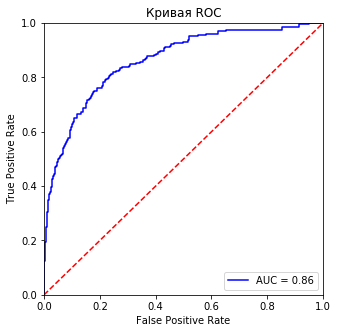

In [16]:
# Создание пула с тестовыми фичами и таргетом
test_pool = Pool(features_test, target_test)

# Собираем значения 
fpr, tpr, _ = get_roc_curve(best_model_3, test_pool)
roc_auc = auc(fpr, tpr)

# Построение графика
plt.figure(figsize = (5,5))
plt.title('Кривая ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Значения True Positive Rate и False Positive Rate для модели catboost находятся достаточно далеко от линии случайной модели. Исходя из этого можно сделать однозначный вывод - использование модели эффективнее случайного предсказания результатов.

Метрика AUC имеет относительно высокое значение, при относительно низком значении F1-меры. Это говорит о не самой успешной работе классификатора в данной конкретной точке (для определенных предсказаний), при этом есть возможность найти порог, для которого результат будет лучше.

### Итоговый вывод <a id="summary"></a>

Лучшими моделями для предсказания намерения клиентов расторгнуть договор с банком стали - случайный лес и catboost. На протяжении всего исследования они показывали примерно равные результаты, и по итогу обе успешно прошли проверку на тестовой выборке, преодолев необходимое значение F1-меры (0.59). 

Различные методы балансировки классов позволили несколько улучшить качество моделей, но не очень значительно (буквально на несколько сотых значения F1-меры). Вполне возможно, что улучшить результаты поможет подбор других гиперпараметров. Этот факт отчасти подтверждает метрика ROC-AUC, которая находится на относительно высоком уровне (0.84 для catboost).

Если выбирать одну конкретную модель для использования - то более интересным вариантом будет catboost. В сравнении с моделью случайного леса, catboost предоставляет возможности для более гибкой настройки, работает ощутимо быстрее, и при этом качество выбранной метрики либо не отличается, либо отличается незначительно.